<a href="https://colab.research.google.com/github/iceaiai/CS-team/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python pillow
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=d7e9bdf7b245fe8f76aaa61df6495618c51b79680b3b6f054563a00bf901a8e9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=480609a83132796011107f03f89784879d3fb48146f6de9b3f041f184a350760
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

#1. Setup and Imports
Import all necessary libraries and ensure that the environment is correctly set up

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import *
from PIL import Image
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms, models
import os
import numpy as np
import kagglehub
import shutil


original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation")
print("Original Path to dataset files:", original_path)
path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")
!ls {path}

100%|██████████| 113M/113M [00:06<00:00, 19.1MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
images	segmaps


In [3]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', 'segmaps']


#2.Configuration class or dictionary to make hyperparameters easily tunable
Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [4]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Training hyperparameters
    num_epochs = 100
    batch_size = 16
    learning_rate = 2e-4
    momentum = 0.9
    weight_decay = 1.5e-4

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride = 1
    padding = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f'current device = {config.device}')


current device = cuda


#3. Dataset preparation:


In [5]:
#Class for preparing data
class ImageDataset:
    def __init__(self, image_folder, mask_folder,transform =None,binary=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.transform = transform
        self.binary = binary
    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array = np.array(mask)
        binary_mask = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): #Dunder method, usage: len(obj)
      return len(self.image_files)
    def __getitem__(self, idx): #Dunder method, usage: obj[idx]
      image_path = os.path.join(self.image_folder, self.image_files[idx])
      mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask
    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

#Class for transforming data:
"""
  1. Resizing;
  2. Converting to tensor;
"""
class SegmentationTransform:
    def __init__(self, resize=None):
        self.resize = resize
        self.image_resize = transforms.Resize(resize)
        self.mask_resize = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor




#4. Data Loader

In [6]:
#Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended
dataset = ImageDataset(config.image_folder, config.mask_folder, transform=transform, binary=True)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data loaders
"""
You can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )

#dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

In [7]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)


1.0

# 5. Model preparation


##5.1 VGG-16


In [8]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 241MB/s]


##5.2 ResNet-50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

##5.3 U-Net

In [ ]:
import segmentation_models_pytorch as smp

Unet_model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',     # Use pretrained weights from ImageNet
    in_channels=1,                  # Input channels (RGB images)
    classes=config.num_classes,     # Number of output classes
    encoder_depth=5,                # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
Unet_model = Unet_model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.7MB/s]


##5.4 DeepLabv3+


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 86.1MB/s]


## 5.5 Mask R CNN

##5.6 Res50-YNET

In [43]:
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize weights
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x5, [x0, x1, x2, x3, x4]
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=3):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )


    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)  # Corrected here
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Squeeze
        y = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        # Excitation
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y
class YNetResNet34_Attention(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_Attention, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=5)
        self.bottleneck2 = Bottleneck(512, num_layers=5)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output

model = YNetResNet34_Attention(num_classes=1, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##5.7 Attention-Res-YNet

In [8]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        reduced_channels = max(1, in_channels // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x
# Encoder with ResNet34 backbone
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)   # [B, 64, H/2, W/2]
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)  # [B, 64, H/4, W/4]
        x2 = self.layer1(x1)   # [B, 64, H/4, W/4]
        x3 = self.layer2(x2)   # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)   # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)   # [B, 512, H/32, W/32]
        return x5, [x0, x1, x2, x3, x4]
# Bottleneck with CBAM
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=4):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                CBAM(in_channels)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
# Decoder with CBAM
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            CBAM(out_channels)
        )

    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output
# Complete YNet with ResNet34 and CBAM
class YNetResNet34_CBAM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_CBAM, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=4)
        self.bottleneck2 = Bottleneck(512, num_layers=4)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output
model = YNetResNet34_CBAM(num_classes=config.num_classes, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 220MB/s]


#6. Training and testing

In [9]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 20:
        return 1.0  # Keep the initial LR
    #elif 10 <= epoch < 20:
        #return 0.3
    elif 20 <= epoch < 30:
        return 0.5
    elif 30 <= epoch < 50:
        return 0.25
    elif 50 <= epoch < 70:
        return 0.2
    else:
        return 0.1

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)
import torch.nn.functional as F

def boundary_loss(y_pred, y_true):
    # Ensure y_pred and y_true have the same number of channels
    assert y_pred.shape == y_true.shape, "Mismatch in shape"

    # Sobel filters
    sobel_kernel = torch.tensor([[[-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]],
                                 [[-1, -2, -1],
                                  [0, 0, 0],
                                  [1, 2, 1]]], dtype=torch.float32).to(y_pred.device)  # Shape: [2, 3, 3]
    sobel_kernel = sobel_kernel.unsqueeze(1)  # Shape: [2, 1, 3, 3]

    # Stack predictions and ground truths
    y_pred = torch.sigmoid(y_pred)  # Ensure y_pred is between 0 and 1
    y_true = y_true.float()

    # Compute gradients
    y_pred_grad = F.conv2d(y_pred, sobel_kernel, padding=1)
    y_true_grad = F.conv2d(y_true, sobel_kernel, padding=1)

    # Compute gradient magnitudes
    y_pred_grad_mag = torch.sqrt(y_pred_grad[:, 0] ** 2 + y_pred_grad[:, 1] ** 2 + 1e-7)
    y_true_grad_mag = torch.sqrt(y_true_grad[:, 0] ** 2 + y_true_grad[:, 1] ** 2 + 1e-7)

    # Compute L1 loss
    loss = F.l1_loss(y_pred_grad_mag, y_true_grad_mag)
    return loss




class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0):#,weight_boundary =1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        #self.weight_boundary = weight_boundary

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        #boundary = boundary_loss(probs, targets)
        return self.weight_bce*bce_loss + self.weight_dice*dice_loss #+ self.weight_boundary*boundary
# BCE + DICE
criterion = CombinedLoss(weight_bce=0.1, weight_dice=1.0)#,weight_boundary=1.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [10]:
from sklearn.metrics import adjusted_rand_score
num_epochs = config.num_epochs
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/100 - Training: 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]


Epoch 1/100, Training Loss: 0.6533


Epoch 1/100 - Validation: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Epoch 1/100, Validation Loss: 0.6893
Precision: 0.0000, Recall: 0.0000, Accuracy: 0.6799
IoU: 0.0000, F1 Score: 0.0000, Dice Coefficient: 0.0000
Pixel Error: 0.3201, Rand Error: 1.0000


Epoch 2/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 2/100, Training Loss: 0.6116


Epoch 2/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 2/100, Validation Loss: 0.6589
Precision: 0.9115, Recall: 0.6616, Accuracy: 0.8711
IoU: 0.6214, F1 Score: 0.7667, Dice Coefficient: 0.7658
Pixel Error: 0.1289, Rand Error: 0.4655


Epoch 3/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch 3/100, Training Loss: 0.5195


Epoch 3/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 3/100, Validation Loss: 0.5280
Precision: 0.9381, Recall: 0.9124, Accuracy: 0.9527
IoU: 0.8570, F1 Score: 0.9251, Dice Coefficient: 0.9224
Pixel Error: 0.0473, Rand Error: 0.1868


Epoch 4/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 4/100, Training Loss: 0.4684


Epoch 4/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 4/100, Validation Loss: 0.5087
Precision: 0.9170, Recall: 0.9591, Accuracy: 0.9591
IoU: 0.8805, F1 Score: 0.9376, Dice Coefficient: 0.9362
Pixel Error: 0.0409, Rand Error: 0.1610


Epoch 5/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 5/100, Training Loss: 0.4433


Epoch 5/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 5/100, Validation Loss: 0.4978
Precision: 0.9390, Recall: 0.9004, Accuracy: 0.9494
IoU: 0.8439, F1 Score: 0.9193, Dice Coefficient: 0.9137
Pixel Error: 0.0506, Rand Error: 0.2014


Epoch 6/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 6/100, Training Loss: 0.4215


Epoch 6/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 6/100, Validation Loss: 0.4636
Precision: 0.8333, Recall: 0.9633, Accuracy: 0.9266
IoU: 0.8075, F1 Score: 0.8936, Dice Coefficient: 0.8929
Pixel Error: 0.0734, Rand Error: 0.2736


Epoch 7/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 7/100, Training Loss: 0.3975


Epoch 7/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 7/100, Validation Loss: 0.4512
Precision: 0.9591, Recall: 0.9106, Accuracy: 0.9589
IoU: 0.8755, F1 Score: 0.9342, Dice Coefficient: 0.9326
Pixel Error: 0.0411, Rand Error: 0.1622


Epoch 8/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch 8/100, Training Loss: 0.3881


Epoch 8/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 8/100, Validation Loss: 0.4088
Precision: 0.9342, Recall: 0.9476, Accuracy: 0.9618
IoU: 0.8870, F1 Score: 0.9408, Dice Coefficient: 0.9393
Pixel Error: 0.0382, Rand Error: 0.1509


Epoch 9/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch 9/100, Training Loss: 0.3729


Epoch 9/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 9/100, Validation Loss: 0.3939
Precision: 0.8852, Recall: 0.9768, Accuracy: 0.9520
IoU: 0.8638, F1 Score: 0.9287, Dice Coefficient: 0.9265
Pixel Error: 0.0480, Rand Error: 0.1869


Epoch 10/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 10/100, Training Loss: 0.3565


Epoch 10/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 10/100, Validation Loss: 0.4109
Precision: 0.9430, Recall: 0.9693, Accuracy: 0.9714
IoU: 0.9138, F1 Score: 0.9560, Dice Coefficient: 0.9548
Pixel Error: 0.0286, Rand Error: 0.1144


Epoch 11/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 11/100, Training Loss: 0.3382


Epoch 11/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 11/100, Validation Loss: 0.3893
Precision: 0.9669, Recall: 0.9462, Accuracy: 0.9724
IoU: 0.9130, F1 Score: 0.9564, Dice Coefficient: 0.9541
Pixel Error: 0.0276, Rand Error: 0.1121


Epoch 12/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.84it/s]


Epoch 12/100, Training Loss: 0.3351


Epoch 12/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Epoch 12/100, Validation Loss: 0.3558
Precision: 0.9002, Recall: 0.9812, Accuracy: 0.9592
IoU: 0.8820, F1 Score: 0.9390, Dice Coefficient: 0.9372
Pixel Error: 0.0408, Rand Error: 0.1606


Epoch 13/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 13/100, Training Loss: 0.3251


Epoch 13/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 13/100, Validation Loss: 0.3715
Precision: 0.9507, Recall: 0.9393, Accuracy: 0.9650
IoU: 0.8969, F1 Score: 0.9450, Dice Coefficient: 0.9453
Pixel Error: 0.0350, Rand Error: 0.1381


Epoch 14/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 14/100, Training Loss: 0.3153


Epoch 14/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


Epoch 14/100, Validation Loss: 0.3588
Precision: 0.9779, Recall: 0.9072, Accuracy: 0.9637
IoU: 0.8831, F1 Score: 0.9412, Dice Coefficient: 0.9372
Pixel Error: 0.0363, Rand Error: 0.1469


Epoch 15/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 15/100, Training Loss: 0.3069


Epoch 15/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 15/100, Validation Loss: 0.3292
Precision: 0.9225, Recall: 0.9554, Accuracy: 0.9600
IoU: 0.8861, F1 Score: 0.9386, Dice Coefficient: 0.9393
Pixel Error: 0.0400, Rand Error: 0.1556


Epoch 16/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 16/100, Training Loss: 0.2891


Epoch 16/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 16/100, Validation Loss: 0.3339
Precision: 0.9689, Recall: 0.9279, Accuracy: 0.9674
IoU: 0.9001, F1 Score: 0.9480, Dice Coefficient: 0.9470
Pixel Error: 0.0326, Rand Error: 0.1304


Epoch 17/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch 17/100, Training Loss: 0.2755


Epoch 17/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 17/100, Validation Loss: 0.2975
Precision: 0.9502, Recall: 0.9614, Accuracy: 0.9715
IoU: 0.9159, F1 Score: 0.9558, Dice Coefficient: 0.9559
Pixel Error: 0.0285, Rand Error: 0.1132


Epoch 18/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 18/100, Training Loss: 0.2589


Epoch 18/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


Epoch 18/100, Validation Loss: 0.3087
Precision: 0.9499, Recall: 0.9690, Accuracy: 0.9737
IoU: 0.9215, F1 Score: 0.9593, Dice Coefficient: 0.9590
Pixel Error: 0.0263, Rand Error: 0.1050


Epoch 19/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 19/100, Training Loss: 0.2550


Epoch 19/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Epoch 19/100, Validation Loss: 0.2566
Precision: 0.9576, Recall: 0.9648, Accuracy: 0.9750
IoU: 0.9256, F1 Score: 0.9612, Dice Coefficient: 0.9612
Pixel Error: 0.0250, Rand Error: 0.0995


Epoch 20/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 20/100, Training Loss: 0.2406


Epoch 20/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Epoch 20/100, Validation Loss: 0.2812
Precision: 0.9365, Recall: 0.9758, Accuracy: 0.9711
IoU: 0.9149, F1 Score: 0.9558, Dice Coefficient: 0.9555
Pixel Error: 0.0289, Rand Error: 0.1148


Epoch 21/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 21/100, Training Loss: 0.2271


Epoch 21/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Epoch 21/100, Validation Loss: 0.2713
Precision: 0.9410, Recall: 0.9720, Accuracy: 0.9715
IoU: 0.9152, F1 Score: 0.9562, Dice Coefficient: 0.9556
Pixel Error: 0.0285, Rand Error: 0.1132


Epoch 22/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch 22/100, Training Loss: 0.2227


Epoch 22/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 22/100, Validation Loss: 0.2576
Precision: 0.9499, Recall: 0.9593, Accuracy: 0.9708
IoU: 0.9132, F1 Score: 0.9545, Dice Coefficient: 0.9545
Pixel Error: 0.0292, Rand Error: 0.1159


Epoch 23/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.84it/s]


Epoch 23/100, Training Loss: 0.2108


Epoch 23/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 23/100, Validation Loss: 0.2456
Precision: 0.9566, Recall: 0.9514, Accuracy: 0.9706
IoU: 0.9124, F1 Score: 0.9540, Dice Coefficient: 0.9540
Pixel Error: 0.0294, Rand Error: 0.1165


Epoch 24/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 24/100, Training Loss: 0.2094


Epoch 24/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Epoch 24/100, Validation Loss: 0.2315
Precision: 0.9540, Recall: 0.9574, Accuracy: 0.9716
IoU: 0.9167, F1 Score: 0.9557, Dice Coefficient: 0.9563
Pixel Error: 0.0284, Rand Error: 0.1122


Epoch 25/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 25/100, Training Loss: 0.1991


Epoch 25/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 25/100, Validation Loss: 0.2504
Precision: 0.9484, Recall: 0.9517, Accuracy: 0.9680
IoU: 0.9016, F1 Score: 0.9500, Dice Coefficient: 0.9477
Pixel Error: 0.0320, Rand Error: 0.1289


Epoch 26/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 26/100, Training Loss: 0.1978


Epoch 26/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 26/100, Validation Loss: 0.2183
Precision: 0.9550, Recall: 0.9626, Accuracy: 0.9735
IoU: 0.9213, F1 Score: 0.9588, Dice Coefficient: 0.9587
Pixel Error: 0.0265, Rand Error: 0.1053


Epoch 27/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch 27/100, Training Loss: 0.1876


Epoch 27/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 27/100, Validation Loss: 0.2098
Precision: 0.9481, Recall: 0.9622, Accuracy: 0.9710
IoU: 0.9155, F1 Score: 0.9551, Dice Coefficient: 0.9557
Pixel Error: 0.0290, Rand Error: 0.1146


Epoch 28/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 28/100, Training Loss: 0.1828


Epoch 28/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 28/100, Validation Loss: 0.2458
Precision: 0.8691, Recall: 0.9839, Accuracy: 0.9474
IoU: 0.8522, F1 Score: 0.9229, Dice Coefficient: 0.9195
Pixel Error: 0.0526, Rand Error: 0.2047


Epoch 29/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 29/100, Training Loss: 0.1757


Epoch 29/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 29/100, Validation Loss: 0.2233
Precision: 0.9592, Recall: 0.9383, Accuracy: 0.9675
IoU: 0.9029, F1 Score: 0.9486, Dice Coefficient: 0.9487
Pixel Error: 0.0325, Rand Error: 0.1291


Epoch 30/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


Epoch 30/100, Training Loss: 0.1729


Epoch 30/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Epoch 30/100, Validation Loss: 0.1985
Precision: 0.9550, Recall: 0.9571, Accuracy: 0.9718
IoU: 0.9148, F1 Score: 0.9560, Dice Coefficient: 0.9552
Pixel Error: 0.0282, Rand Error: 0.1132


Epoch 31/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 31/100, Training Loss: 0.1665


Epoch 31/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 31/100, Validation Loss: 0.2073
Precision: 0.9559, Recall: 0.9608, Accuracy: 0.9732
IoU: 0.9196, F1 Score: 0.9583, Dice Coefficient: 0.9579
Pixel Error: 0.0268, Rand Error: 0.1071


Epoch 32/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.84it/s]


Epoch 32/100, Training Loss: 0.1639


Epoch 32/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 32/100, Validation Loss: 0.1893
Precision: 0.9575, Recall: 0.9628, Accuracy: 0.9744
IoU: 0.9234, F1 Score: 0.9601, Dice Coefficient: 0.9600
Pixel Error: 0.0256, Rand Error: 0.1024


Epoch 33/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 33/100, Training Loss: 0.1672


Epoch 33/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 33/100, Validation Loss: 0.1945
Precision: 0.9520, Recall: 0.9680, Accuracy: 0.9741
IoU: 0.9232, F1 Score: 0.9599, Dice Coefficient: 0.9599
Pixel Error: 0.0259, Rand Error: 0.1032


Epoch 34/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 34/100, Training Loss: 0.1627


Epoch 34/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.75s/it]


Epoch 34/100, Validation Loss: 0.1847
Precision: 0.9585, Recall: 0.9565, Accuracy: 0.9728
IoU: 0.9206, F1 Score: 0.9575, Dice Coefficient: 0.9585
Pixel Error: 0.0272, Rand Error: 0.1074


Epoch 35/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 35/100, Training Loss: 0.1548


Epoch 35/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 35/100, Validation Loss: 0.1792
Precision: 0.9570, Recall: 0.9621, Accuracy: 0.9741
IoU: 0.9240, F1 Score: 0.9596, Dice Coefficient: 0.9604
Pixel Error: 0.0259, Rand Error: 0.1029


Epoch 36/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 36/100, Training Loss: 0.1516


Epoch 36/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Epoch 36/100, Validation Loss: 0.1804
Precision: 0.9567, Recall: 0.9641, Accuracy: 0.9745
IoU: 0.9251, F1 Score: 0.9604, Dice Coefficient: 0.9610
Pixel Error: 0.0255, Rand Error: 0.1012


Epoch 37/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 37/100, Training Loss: 0.1486


Epoch 37/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 37/100, Validation Loss: 0.1811
Precision: 0.9602, Recall: 0.9626, Accuracy: 0.9752
IoU: 0.9268, F1 Score: 0.9614, Dice Coefficient: 0.9619
Pixel Error: 0.0248, Rand Error: 0.0985


Epoch 38/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 38/100, Training Loss: 0.1475


Epoch 38/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 38/100, Validation Loss: 0.1772
Precision: 0.9497, Recall: 0.9713, Accuracy: 0.9743
IoU: 0.9250, F1 Score: 0.9603, Dice Coefficient: 0.9609
Pixel Error: 0.0257, Rand Error: 0.1019


Epoch 39/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 39/100, Training Loss: 0.1483


Epoch 39/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 39/100, Validation Loss: 0.1795
Precision: 0.9562, Recall: 0.9632, Accuracy: 0.9741
IoU: 0.9245, F1 Score: 0.9597, Dice Coefficient: 0.9606
Pixel Error: 0.0259, Rand Error: 0.1024


Epoch 40/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 40/100, Training Loss: 0.1481


Epoch 40/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 40/100, Validation Loss: 0.1783
Precision: 0.9527, Recall: 0.9689, Accuracy: 0.9746
IoU: 0.9256, F1 Score: 0.9607, Dice Coefficient: 0.9612
Pixel Error: 0.0254, Rand Error: 0.1007


Epoch 41/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 41/100, Training Loss: 0.1466


Epoch 41/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 41/100, Validation Loss: 0.1747
Precision: 0.9555, Recall: 0.9635, Accuracy: 0.9739
IoU: 0.9238, F1 Score: 0.9595, Dice Coefficient: 0.9602
Pixel Error: 0.0261, Rand Error: 0.1032


Epoch 42/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 42/100, Training Loss: 0.1496


Epoch 42/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Epoch 42/100, Validation Loss: 0.1709
Precision: 0.9541, Recall: 0.9668, Accuracy: 0.9745
IoU: 0.9253, F1 Score: 0.9604, Dice Coefficient: 0.9610
Pixel Error: 0.0255, Rand Error: 0.1011


Epoch 43/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 43/100, Training Loss: 0.1387


Epoch 43/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 43/100, Validation Loss: 0.1748
Precision: 0.9583, Recall: 0.9475, Accuracy: 0.9700
IoU: 0.9112, F1 Score: 0.9529, Dice Coefficient: 0.9534
Pixel Error: 0.0300, Rand Error: 0.1181


Epoch 44/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 44/100, Training Loss: 0.1384


Epoch 44/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 44/100, Validation Loss: 0.2467
Precision: 0.8695, Recall: 0.9039, Accuracy: 0.9258
IoU: 0.7949, F1 Score: 0.8863, Dice Coefficient: 0.8856
Pixel Error: 0.0742, Rand Error: 0.2796


Epoch 45/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 45/100, Training Loss: 0.1444


Epoch 45/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 45/100, Validation Loss: 0.1782
Precision: 0.9636, Recall: 0.9539, Accuracy: 0.9737
IoU: 0.9221, F1 Score: 0.9587, Dice Coefficient: 0.9592
Pixel Error: 0.0263, Rand Error: 0.1046


Epoch 46/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 46/100, Training Loss: 0.1424


Epoch 46/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 46/100, Validation Loss: 0.1604
Precision: 0.9521, Recall: 0.9664, Accuracy: 0.9737
IoU: 0.9232, F1 Score: 0.9592, Dice Coefficient: 0.9599
Pixel Error: 0.0263, Rand Error: 0.1044


Epoch 47/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 47/100, Training Loss: 0.1349


Epoch 47/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 47/100, Validation Loss: 0.1640
Precision: 0.9351, Recall: 0.9748, Accuracy: 0.9703
IoU: 0.9138, F1 Score: 0.9545, Dice Coefficient: 0.9547
Pixel Error: 0.0297, Rand Error: 0.1174


Epoch 48/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 48/100, Training Loss: 0.1385


Epoch 48/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 48/100, Validation Loss: 0.1716
Precision: 0.9597, Recall: 0.9569, Accuracy: 0.9733
IoU: 0.9217, F1 Score: 0.9583, Dice Coefficient: 0.9591
Pixel Error: 0.0267, Rand Error: 0.1056


Epoch 49/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 49/100, Training Loss: 0.1363


Epoch 49/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 49/100, Validation Loss: 0.1491
Precision: 0.9591, Recall: 0.9614, Accuracy: 0.9745
IoU: 0.9252, F1 Score: 0.9602, Dice Coefficient: 0.9610
Pixel Error: 0.0255, Rand Error: 0.1011


Epoch 50/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 50/100, Training Loss: 0.1360


Epoch 50/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 50/100, Validation Loss: 0.1524
Precision: 0.9667, Recall: 0.9522, Accuracy: 0.9742
IoU: 0.9236, F1 Score: 0.9594, Dice Coefficient: 0.9602
Pixel Error: 0.0258, Rand Error: 0.1026


Epoch 51/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 51/100, Training Loss: 0.1294


Epoch 51/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 51/100, Validation Loss: 0.1614
Precision: 0.9517, Recall: 0.9669, Accuracy: 0.9737
IoU: 0.9231, F1 Score: 0.9593, Dice Coefficient: 0.9599
Pixel Error: 0.0263, Rand Error: 0.1043


Epoch 52/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 52/100, Training Loss: 0.1368


Epoch 52/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 52/100, Validation Loss: 0.1603
Precision: 0.9594, Recall: 0.9614, Accuracy: 0.9746
IoU: 0.9257, F1 Score: 0.9604, Dice Coefficient: 0.9613
Pixel Error: 0.0254, Rand Error: 0.1006


Epoch 53/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 53/100, Training Loss: 0.1342


Epoch 53/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 53/100, Validation Loss: 0.1609
Precision: 0.9559, Recall: 0.9654, Accuracy: 0.9746
IoU: 0.9256, F1 Score: 0.9606, Dice Coefficient: 0.9613
Pixel Error: 0.0254, Rand Error: 0.1007


Epoch 54/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 54/100, Training Loss: 0.1284


Epoch 54/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 54/100, Validation Loss: 0.1620
Precision: 0.9575, Recall: 0.9637, Accuracy: 0.9747
IoU: 0.9259, F1 Score: 0.9606, Dice Coefficient: 0.9614
Pixel Error: 0.0253, Rand Error: 0.1004


Epoch 55/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch 55/100, Training Loss: 0.1252


Epoch 55/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 55/100, Validation Loss: 0.1574
Precision: 0.9589, Recall: 0.9634, Accuracy: 0.9751
IoU: 0.9268, F1 Score: 0.9611, Dice Coefficient: 0.9619
Pixel Error: 0.0249, Rand Error: 0.0990


Epoch 56/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 56/100, Training Loss: 0.1313


Epoch 56/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 56/100, Validation Loss: 0.1539
Precision: 0.9589, Recall: 0.9622, Accuracy: 0.9747
IoU: 0.9257, F1 Score: 0.9605, Dice Coefficient: 0.9613
Pixel Error: 0.0253, Rand Error: 0.1005


Epoch 57/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 57/100, Training Loss: 0.1322


Epoch 57/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 57/100, Validation Loss: 0.1529
Precision: 0.9571, Recall: 0.9646, Accuracy: 0.9748
IoU: 0.9258, F1 Score: 0.9608, Dice Coefficient: 0.9614
Pixel Error: 0.0252, Rand Error: 0.1001


Epoch 58/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 58/100, Training Loss: 0.1268


Epoch 58/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 58/100, Validation Loss: 0.1543
Precision: 0.9662, Recall: 0.9557, Accuracy: 0.9751
IoU: 0.9261, F1 Score: 0.9609, Dice Coefficient: 0.9615
Pixel Error: 0.0249, Rand Error: 0.0989


Epoch 59/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 59/100, Training Loss: 0.1287


Epoch 59/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 59/100, Validation Loss: 0.1570
Precision: 0.9558, Recall: 0.9656, Accuracy: 0.9747
IoU: 0.9256, F1 Score: 0.9607, Dice Coefficient: 0.9613
Pixel Error: 0.0253, Rand Error: 0.1005


Epoch 60/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 60/100, Training Loss: 0.1230


Epoch 60/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 60/100, Validation Loss: 0.1447
Precision: 0.9675, Recall: 0.9554, Accuracy: 0.9755
IoU: 0.9274, F1 Score: 0.9614, Dice Coefficient: 0.9622
Pixel Error: 0.0245, Rand Error: 0.0973


Epoch 61/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


Epoch 61/100, Training Loss: 0.1284


Epoch 61/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Epoch 61/100, Validation Loss: 0.1475
Precision: 0.9571, Recall: 0.9632, Accuracy: 0.9744
IoU: 0.9256, F1 Score: 0.9601, Dice Coefficient: 0.9612
Pixel Error: 0.0256, Rand Error: 0.1013


Epoch 62/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 62/100, Training Loss: 0.1235


Epoch 62/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 62/100, Validation Loss: 0.1497
Precision: 0.9641, Recall: 0.9565, Accuracy: 0.9747
IoU: 0.9259, F1 Score: 0.9603, Dice Coefficient: 0.9614
Pixel Error: 0.0253, Rand Error: 0.1002


Epoch 63/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 63/100, Training Loss: 0.1183


Epoch 63/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 63/100, Validation Loss: 0.1413
Precision: 0.9607, Recall: 0.9649, Accuracy: 0.9761
IoU: 0.9296, F1 Score: 0.9628, Dice Coefficient: 0.9634
Pixel Error: 0.0239, Rand Error: 0.0950


Epoch 64/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 64/100, Training Loss: 0.1191


Epoch 64/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 64/100, Validation Loss: 0.1424
Precision: 0.9542, Recall: 0.9712, Accuracy: 0.9759
IoU: 0.9292, F1 Score: 0.9626, Dice Coefficient: 0.9632
Pixel Error: 0.0241, Rand Error: 0.0959


Epoch 65/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 65/100, Training Loss: 0.1247


Epoch 65/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 65/100, Validation Loss: 0.1483
Precision: 0.9624, Recall: 0.9615, Accuracy: 0.9756
IoU: 0.9284, F1 Score: 0.9619, Dice Coefficient: 0.9627
Pixel Error: 0.0244, Rand Error: 0.0967


Epoch 66/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 66/100, Training Loss: 0.1179


Epoch 66/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 66/100, Validation Loss: 0.1475
Precision: 0.9604, Recall: 0.9633, Accuracy: 0.9755
IoU: 0.9282, F1 Score: 0.9619, Dice Coefficient: 0.9626
Pixel Error: 0.0245, Rand Error: 0.0971


Epoch 67/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 67/100, Training Loss: 0.1146


Epoch 67/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 67/100, Validation Loss: 0.1484
Precision: 0.9520, Recall: 0.9714, Accuracy: 0.9751
IoU: 0.9273, F1 Score: 0.9616, Dice Coefficient: 0.9622
Pixel Error: 0.0249, Rand Error: 0.0986


Epoch 68/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 68/100, Training Loss: 0.1132


Epoch 68/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 68/100, Validation Loss: 0.1424
Precision: 0.9492, Recall: 0.9729, Accuracy: 0.9747
IoU: 0.9263, F1 Score: 0.9609, Dice Coefficient: 0.9616
Pixel Error: 0.0253, Rand Error: 0.1004


Epoch 69/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 69/100, Training Loss: 0.1145


Epoch 69/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 69/100, Validation Loss: 0.1399
Precision: 0.9529, Recall: 0.9699, Accuracy: 0.9750
IoU: 0.9270, F1 Score: 0.9613, Dice Coefficient: 0.9620
Pixel Error: 0.0250, Rand Error: 0.0990


Epoch 70/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 70/100, Training Loss: 0.1149


Epoch 70/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 70/100, Validation Loss: 0.1457
Precision: 0.9597, Recall: 0.9640, Accuracy: 0.9755
IoU: 0.9286, F1 Score: 0.9618, Dice Coefficient: 0.9628
Pixel Error: 0.0245, Rand Error: 0.0969


Epoch 71/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 71/100, Training Loss: 0.1164


Epoch 71/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 71/100, Validation Loss: 0.1518
Precision: 0.9601, Recall: 0.9634, Accuracy: 0.9755
IoU: 0.9285, F1 Score: 0.9618, Dice Coefficient: 0.9628
Pixel Error: 0.0245, Rand Error: 0.0971


Epoch 72/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 72/100, Training Loss: 0.1105


Epoch 72/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 72/100, Validation Loss: 0.1434
Precision: 0.9581, Recall: 0.9661, Accuracy: 0.9756
IoU: 0.9289, F1 Score: 0.9621, Dice Coefficient: 0.9630
Pixel Error: 0.0244, Rand Error: 0.0966


Epoch 73/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 73/100, Training Loss: 0.1118


Epoch 73/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 73/100, Validation Loss: 0.1426
Precision: 0.9560, Recall: 0.9685, Accuracy: 0.9757
IoU: 0.9289, F1 Score: 0.9622, Dice Coefficient: 0.9630
Pixel Error: 0.0243, Rand Error: 0.0965


Epoch 74/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 74/100, Training Loss: 0.1191


Epoch 74/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 74/100, Validation Loss: 0.1475
Precision: 0.9558, Recall: 0.9689, Accuracy: 0.9757
IoU: 0.9289, F1 Score: 0.9623, Dice Coefficient: 0.9630
Pixel Error: 0.0243, Rand Error: 0.0964


Epoch 75/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 75/100, Training Loss: 0.1136


Epoch 75/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 75/100, Validation Loss: 0.1432
Precision: 0.9556, Recall: 0.9693, Accuracy: 0.9757
IoU: 0.9291, F1 Score: 0.9624, Dice Coefficient: 0.9631
Pixel Error: 0.0243, Rand Error: 0.0962


Epoch 76/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


Epoch 76/100, Training Loss: 0.1136


Epoch 76/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 76/100, Validation Loss: 0.1430
Precision: 0.9560, Recall: 0.9699, Accuracy: 0.9761
IoU: 0.9297, F1 Score: 0.9629, Dice Coefficient: 0.9635
Pixel Error: 0.0239, Rand Error: 0.0950


Epoch 77/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 77/100, Training Loss: 0.1127


Epoch 77/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 77/100, Validation Loss: 0.1391
Precision: 0.9577, Recall: 0.9690, Accuracy: 0.9764
IoU: 0.9304, F1 Score: 0.9633, Dice Coefficient: 0.9638
Pixel Error: 0.0236, Rand Error: 0.0940


Epoch 78/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 78/100, Training Loss: 0.1104


Epoch 78/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 78/100, Validation Loss: 0.1370
Precision: 0.9592, Recall: 0.9667, Accuracy: 0.9762
IoU: 0.9301, F1 Score: 0.9629, Dice Coefficient: 0.9637
Pixel Error: 0.0238, Rand Error: 0.0946


Epoch 79/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 79/100, Training Loss: 0.1181


Epoch 79/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


Epoch 79/100, Validation Loss: 0.1406
Precision: 0.9582, Recall: 0.9655, Accuracy: 0.9755
IoU: 0.9286, F1 Score: 0.9619, Dice Coefficient: 0.9628
Pixel Error: 0.0245, Rand Error: 0.0971


Epoch 80/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 80/100, Training Loss: 0.1118


Epoch 80/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 80/100, Validation Loss: 0.1394
Precision: 0.9583, Recall: 0.9658, Accuracy: 0.9756
IoU: 0.9287, F1 Score: 0.9620, Dice Coefficient: 0.9629
Pixel Error: 0.0244, Rand Error: 0.0967


Epoch 81/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 81/100, Training Loss: 0.1119


Epoch 81/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 81/100, Validation Loss: 0.1442
Precision: 0.9602, Recall: 0.9643, Accuracy: 0.9758
IoU: 0.9293, F1 Score: 0.9622, Dice Coefficient: 0.9632
Pixel Error: 0.0242, Rand Error: 0.0960


Epoch 82/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


Epoch 82/100, Training Loss: 0.1060


Epoch 82/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 82/100, Validation Loss: 0.1356
Precision: 0.9633, Recall: 0.9616, Accuracy: 0.9760
IoU: 0.9297, F1 Score: 0.9624, Dice Coefficient: 0.9634
Pixel Error: 0.0240, Rand Error: 0.0952


Epoch 83/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.82it/s]


Epoch 83/100, Training Loss: 0.1080


Epoch 83/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 83/100, Validation Loss: 0.1394
Precision: 0.9598, Recall: 0.9646, Accuracy: 0.9758
IoU: 0.9292, F1 Score: 0.9622, Dice Coefficient: 0.9632
Pixel Error: 0.0242, Rand Error: 0.0961


Epoch 84/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 84/100, Training Loss: 0.1075


Epoch 84/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 84/100, Validation Loss: 0.1357
Precision: 0.9589, Recall: 0.9652, Accuracy: 0.9756
IoU: 0.9289, F1 Score: 0.9620, Dice Coefficient: 0.9630
Pixel Error: 0.0244, Rand Error: 0.0966


Epoch 85/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 85/100, Training Loss: 0.1158


Epoch 85/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 85/100, Validation Loss: 0.1437
Precision: 0.9618, Recall: 0.9620, Accuracy: 0.9756
IoU: 0.9288, F1 Score: 0.9619, Dice Coefficient: 0.9630
Pixel Error: 0.0244, Rand Error: 0.0966


Epoch 86/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 86/100, Training Loss: 0.1145


Epoch 86/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 86/100, Validation Loss: 0.1488
Precision: 0.9601, Recall: 0.9630, Accuracy: 0.9754
IoU: 0.9282, F1 Score: 0.9616, Dice Coefficient: 0.9626
Pixel Error: 0.0246, Rand Error: 0.0976


Epoch 87/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 87/100, Training Loss: 0.1043


Epoch 87/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 87/100, Validation Loss: 0.1347
Precision: 0.9644, Recall: 0.9621, Accuracy: 0.9765
IoU: 0.9309, F1 Score: 0.9632, Dice Coefficient: 0.9641
Pixel Error: 0.0235, Rand Error: 0.0933


Epoch 88/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 88/100, Training Loss: 0.1088


Epoch 88/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 88/100, Validation Loss: 0.1323
Precision: 0.9694, Recall: 0.9568, Accuracy: 0.9765
IoU: 0.9304, F1 Score: 0.9631, Dice Coefficient: 0.9638
Pixel Error: 0.0235, Rand Error: 0.0934


Epoch 89/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 89/100, Training Loss: 0.1037


Epoch 89/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 89/100, Validation Loss: 0.1292
Precision: 0.9579, Recall: 0.9681, Accuracy: 0.9762
IoU: 0.9298, F1 Score: 0.9630, Dice Coefficient: 0.9635
Pixel Error: 0.0238, Rand Error: 0.0948


Epoch 90/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


Epoch 90/100, Training Loss: 0.1048


Epoch 90/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 90/100, Validation Loss: 0.1337
Precision: 0.9577, Recall: 0.9676, Accuracy: 0.9759
IoU: 0.9295, F1 Score: 0.9626, Dice Coefficient: 0.9633
Pixel Error: 0.0241, Rand Error: 0.0955


Epoch 91/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 91/100, Training Loss: 0.1060


Epoch 91/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 91/100, Validation Loss: 0.1303
Precision: 0.9615, Recall: 0.9609, Accuracy: 0.9752
IoU: 0.9274, F1 Score: 0.9612, Dice Coefficient: 0.9622
Pixel Error: 0.0248, Rand Error: 0.0983


Epoch 92/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 92/100, Training Loss: 0.1008


Epoch 92/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 92/100, Validation Loss: 0.1306
Precision: 0.9610, Recall: 0.9640, Accuracy: 0.9760
IoU: 0.9294, F1 Score: 0.9625, Dice Coefficient: 0.9633
Pixel Error: 0.0240, Rand Error: 0.0954


Epoch 93/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 93/100, Training Loss: 0.1091


Epoch 93/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Epoch 93/100, Validation Loss: 0.1393
Precision: 0.9577, Recall: 0.9656, Accuracy: 0.9753
IoU: 0.9280, F1 Score: 0.9616, Dice Coefficient: 0.9625
Pixel Error: 0.0247, Rand Error: 0.0977


Epoch 94/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


Epoch 94/100, Training Loss: 0.1055


Epoch 94/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 94/100, Validation Loss: 0.1349
Precision: 0.9570, Recall: 0.9654, Accuracy: 0.9750
IoU: 0.9272, F1 Score: 0.9612, Dice Coefficient: 0.9621
Pixel Error: 0.0250, Rand Error: 0.0989


Epoch 95/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 95/100, Training Loss: 0.1074


Epoch 95/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 95/100, Validation Loss: 0.1449
Precision: 0.9520, Recall: 0.9700, Accuracy: 0.9748
IoU: 0.9265, F1 Score: 0.9610, Dice Coefficient: 0.9617
Pixel Error: 0.0252, Rand Error: 0.0999


Epoch 96/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 96/100, Training Loss: 0.1050


Epoch 96/100 - Validation: 100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Epoch 96/100, Validation Loss: 0.1323
Precision: 0.9570, Recall: 0.9615, Accuracy: 0.9738
IoU: 0.9240, F1 Score: 0.9592, Dice Coefficient: 0.9604
Pixel Error: 0.0262, Rand Error: 0.1033


Epoch 97/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


Epoch 97/100, Training Loss: 0.1055


Epoch 97/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 97/100, Validation Loss: 0.1321
Precision: 0.9701, Recall: 0.9537, Accuracy: 0.9758
IoU: 0.9289, F1 Score: 0.9618, Dice Coefficient: 0.9630
Pixel Error: 0.0242, Rand Error: 0.0960


Epoch 98/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 98/100, Training Loss: 0.1031


Epoch 98/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 98/100, Validation Loss: 0.1374
Precision: 0.9643, Recall: 0.9611, Accuracy: 0.9761
IoU: 0.9302, F1 Score: 0.9627, Dice Coefficient: 0.9637
Pixel Error: 0.0239, Rand Error: 0.0946


Epoch 99/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 99/100, Training Loss: 0.1038


Epoch 99/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch 99/100, Validation Loss: 0.1323
Precision: 0.9649, Recall: 0.9613, Accuracy: 0.9764
IoU: 0.9310, F1 Score: 0.9631, Dice Coefficient: 0.9641
Pixel Error: 0.0236, Rand Error: 0.0935


Epoch 100/100 - Training: 100%|██████████| 18/18 [00:04<00:00,  3.80it/s]


Epoch 100/100, Training Loss: 0.1023


Epoch 100/100 - Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]

Epoch 100/100, Validation Loss: 0.1367
Precision: 0.9627, Recall: 0.9644, Accuracy: 0.9767
IoU: 0.9316, F1 Score: 0.9636, Dice Coefficient: 0.9645
Pixel Error: 0.0233, Rand Error: 0.0927


##6.2 Testing



In [11]:
model.eval()
test_loss = 0.0

# Initialize lists for metrics with "data_testing" prefix
precision_data_testing = []
recall_data_testing = []
accuracy_data_testing = []
iou_data_testing = []
f1_data_testing = []
dice_coeff_data_testing = []
rand_error_data_testing = []
pixel_error_data_testing = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)

        # Calculate loss
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

        # Threshold predictions for metrics (e.g., using 0.5 as the threshold)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate metrics
        tp = (preds * masks).sum().item()  # True Positives
        fp = (preds * (1 - masks)).sum().item()  # False Positives
        fn = ((1 - preds) * masks).sum().item()  # False Negatives
        tn = ((1 - preds) * (1 - masks)).sum().item()  # True Negatives

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        dice_coeff = 2 * tp / (2 * tp + fp + fn + 1e-6)
        pixel_error = 1 - accuracy
        rand_error = 1 - (tp + tn) / (tp + fp + fn + tn + 1e-6)

        # Append metrics to lists
        precision_data_testing.append(precision)
        recall_data_testing.append(recall)
        accuracy_data_testing.append(accuracy)
        iou_data_testing.append(iou)
        f1_data_testing.append(f1)
        dice_coeff_data_testing.append(dice_coeff)
        pixel_error_data_testing.append(pixel_error)
        rand_error_data_testing.append(rand_error)

# Compute average test loss
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Compute average metrics
avg_precision = sum(precision_data_testing) / len(precision_data_testing)
avg_recall = sum(recall_data_testing) / len(recall_data_testing)
avg_accuracy = sum(accuracy_data_testing) / len(accuracy_data_testing)
avg_iou = sum(iou_data_testing) / len(iou_data_testing)
avg_f1 = sum(f1_data_testing) / len(f1_data_testing)
avg_dice_coeff = sum(dice_coeff_data_testing) / len(dice_coeff_data_testing)
avg_pixel_error = sum(pixel_error_data_testing) / len(pixel_error_data_testing)
avg_rand_error = sum(rand_error_data_testing) / len(rand_error_data_testing)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coeff:.4f}")
print(f"Average Pixel Error: {avg_pixel_error:.4f}")
print(f"Average Rand Error: {avg_rand_error:.4f}")


Testing: 100%|██████████| 6/6 [00:01<00:00,  5.57it/s]

Test Loss: 0.1695
Average Precision: 0.9431
Average Recall: 0.9495
Average Accuracy: 0.9684
Average IoU: 0.8994
Average F1 Score: 0.9458
Average Dice Coefficient: 0.9458
Average Pixel Error: 0.0316
Average Rand Error: 0.0316


In [12]:
import pandas as pd

results_data = {
    "precision": precision_data_testing,
    "recall": recall_data_testing,
    "accuracy": accuracy_data_testing,
    "iou": iou_data_testing,
    "f1": f1_data_testing,
    "dice_coeff": dice_coeff_data_testing,
    "pixel_error": pixel_error_data_testing,
    "rand_error": rand_error_data_testing
}

# Convert to DataFrame
results_df = pd.DataFrame(results_data)

# Compute average metrics and append to the DataFrame
average_row = {
    "precision": sum(precision_data_testing) / len(precision_data_testing),
    "recall": sum(recall_data_testing) / len(recall_data_testing),
    "accuracy": sum(accuracy_data_testing) / len(accuracy_data_testing),
    "iou": sum(iou_data_testing) / len(iou_data_testing),
    "f1": sum(f1_data_testing) / len(f1_data_testing),
    "dice_coeff": sum(dice_coeff_data_testing) / len(dice_coeff_data_testing),
    "pixel_error": sum(pixel_error_data_testing) / len(pixel_error_data_testing),
    "rand_error": sum(rand_error_data_testing) / len(rand_error_data_testing)
}

average_row_df = pd.DataFrame([average_row])
results_df = pd.concat([results_df, average_row_df], ignore_index=True)
results_df.loc[len(results_df) - 1, 'epoch'] = 'Average'
results_df.to_csv("testing_results.csv", index=False)


##6.3 Saving and loading the model

In [13]:
# Save the model
torch.save(model.state_dict(), 'Ynet34-atten_model.pth')

# Load the model
model.load_state_dict(torch.load('Ynet34-atten_model.pth'))
model.eval()

<ipython-input-13-4c799bb9b1d1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Ynet34-atten_model.pth'))


YNetResNet34_CBAM(
  (encoder): ResNet34Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

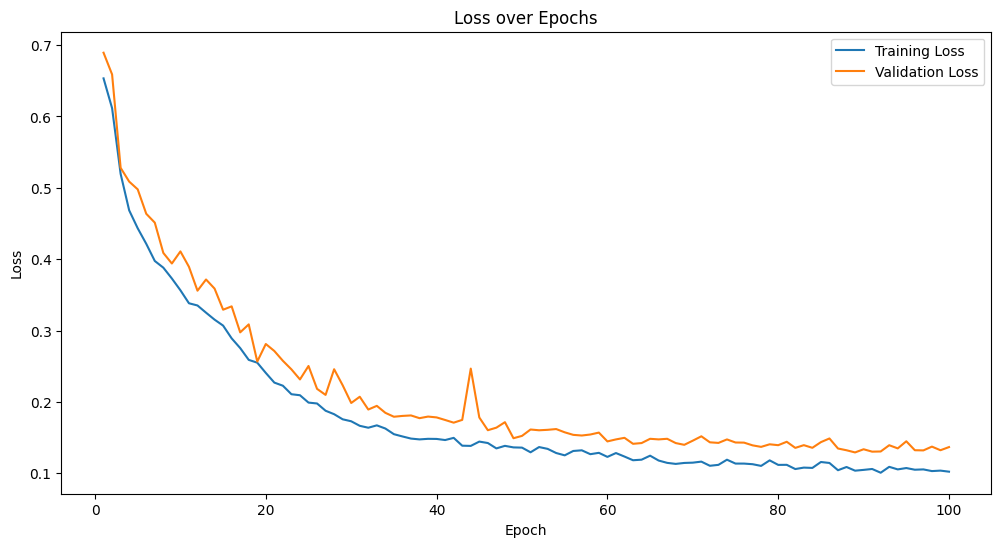

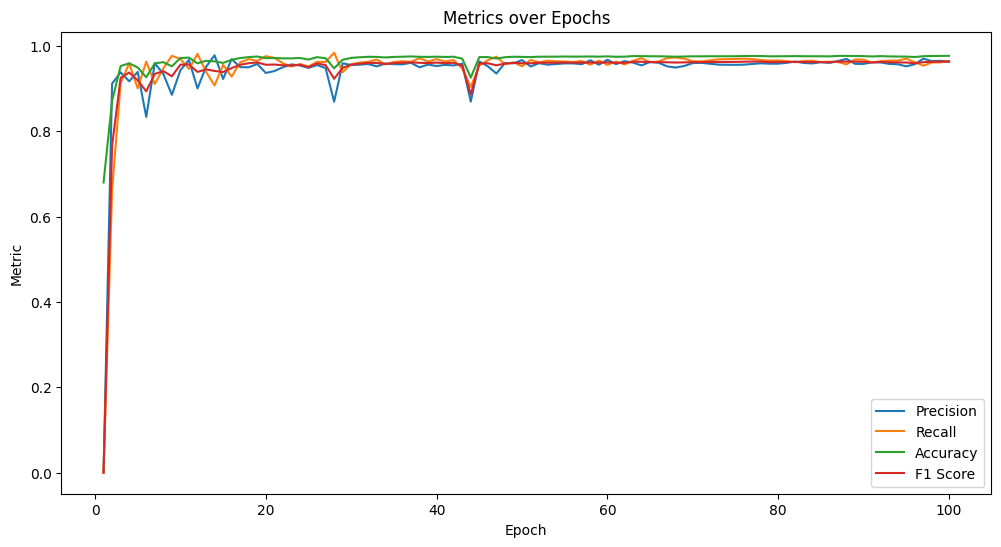

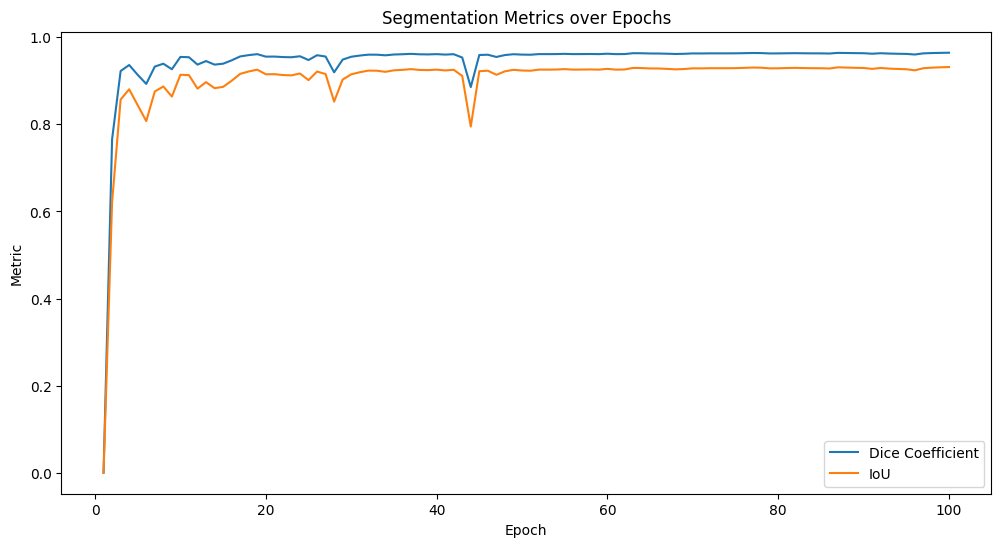

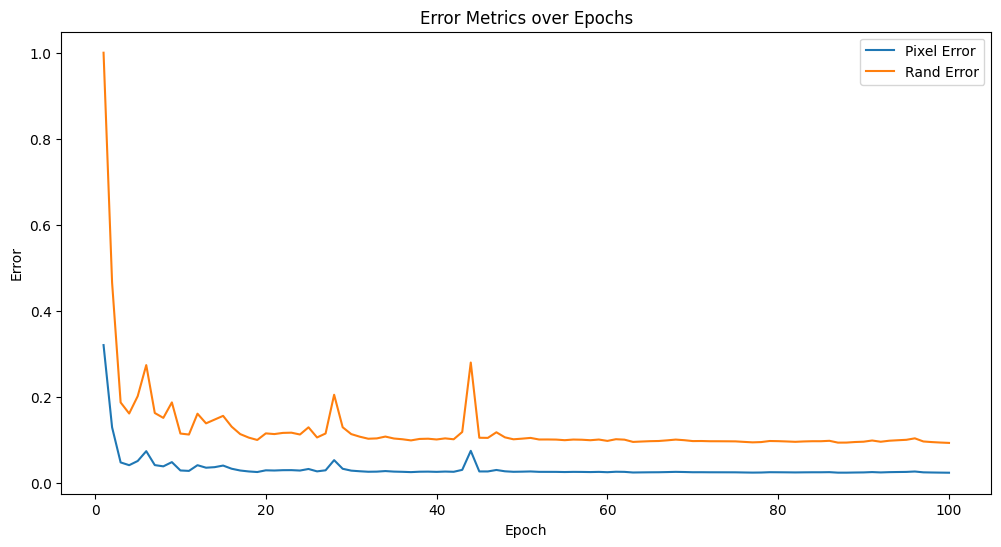

In [14]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.savefig('metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.savefig('segmentation_metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.savefig('error_metrics.png')
plt.show()



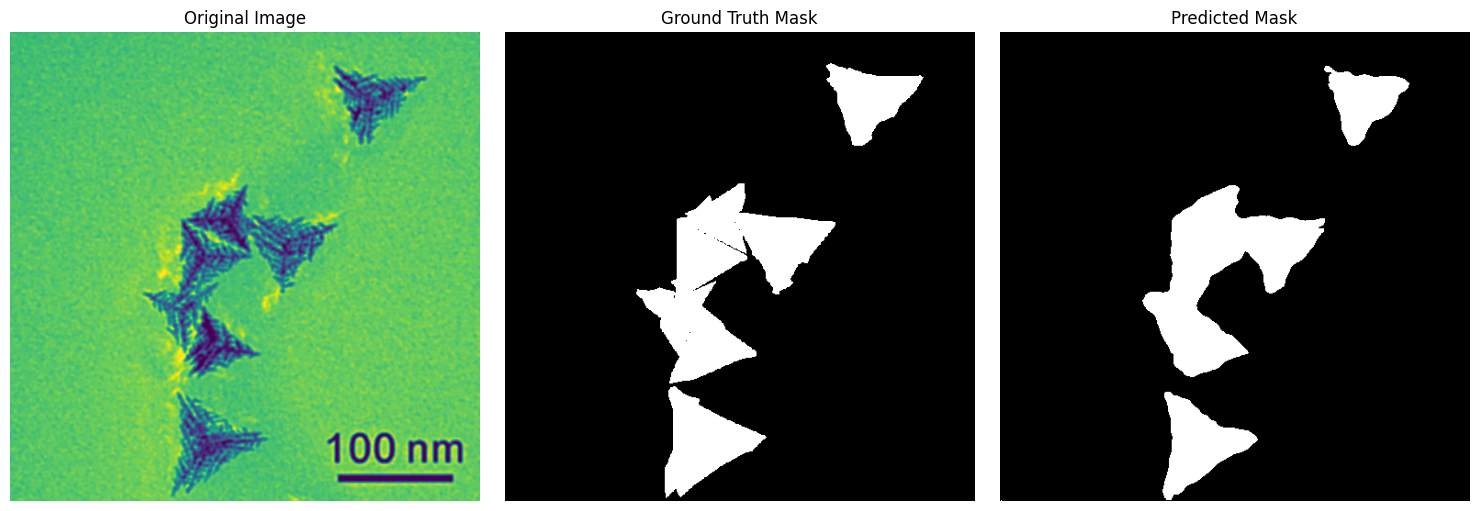

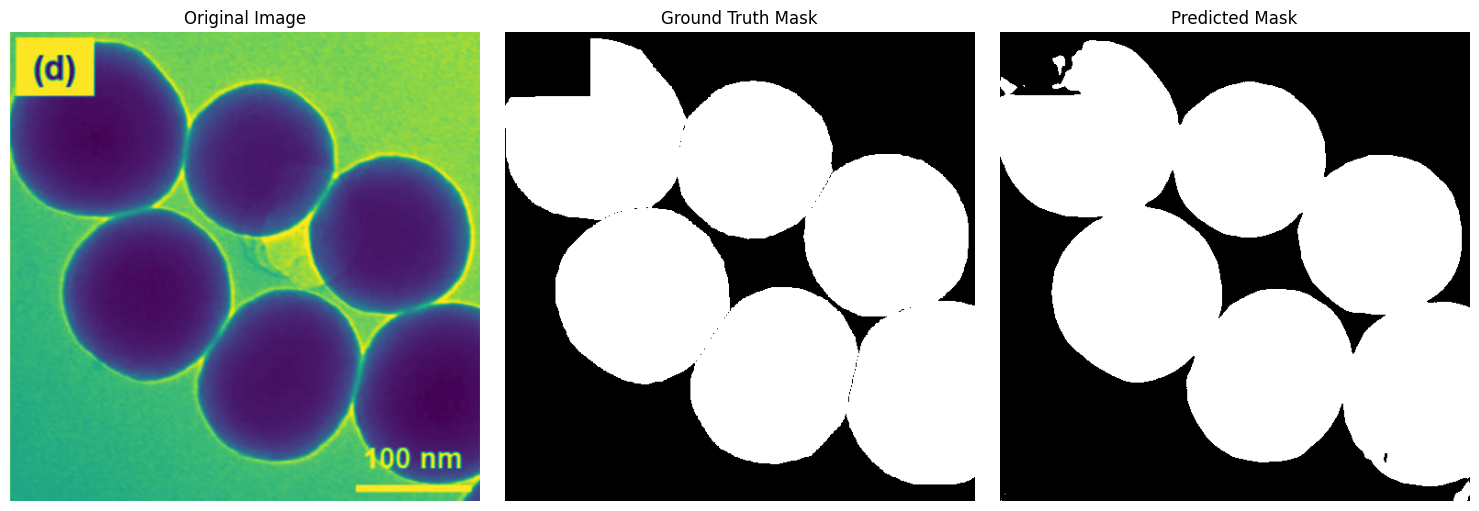

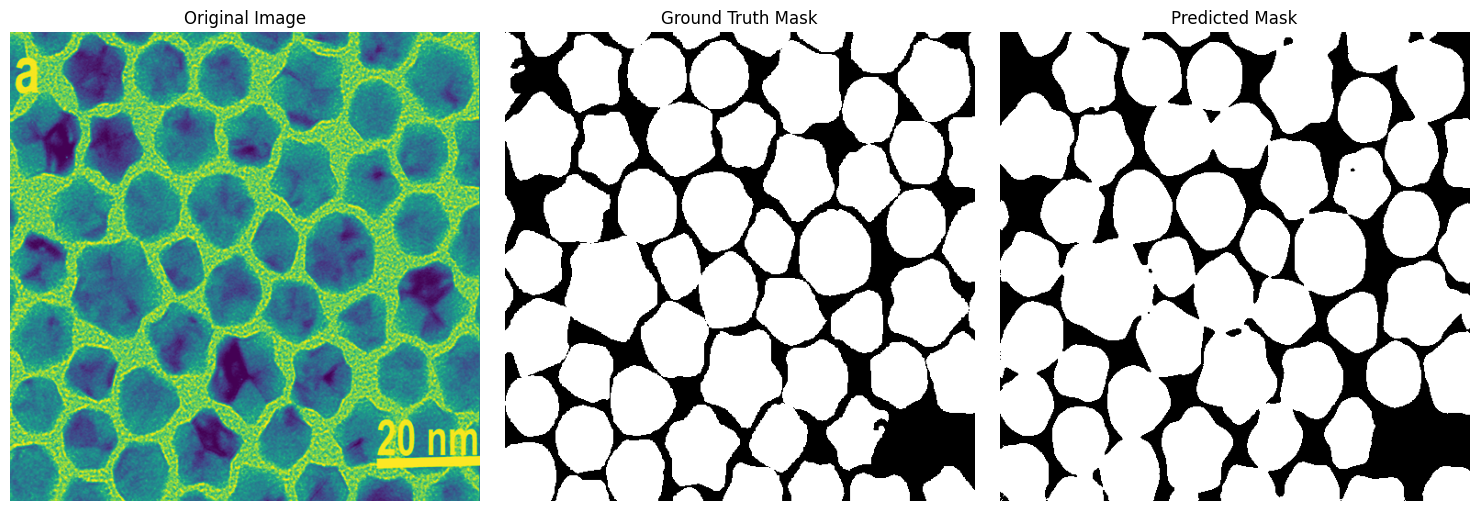

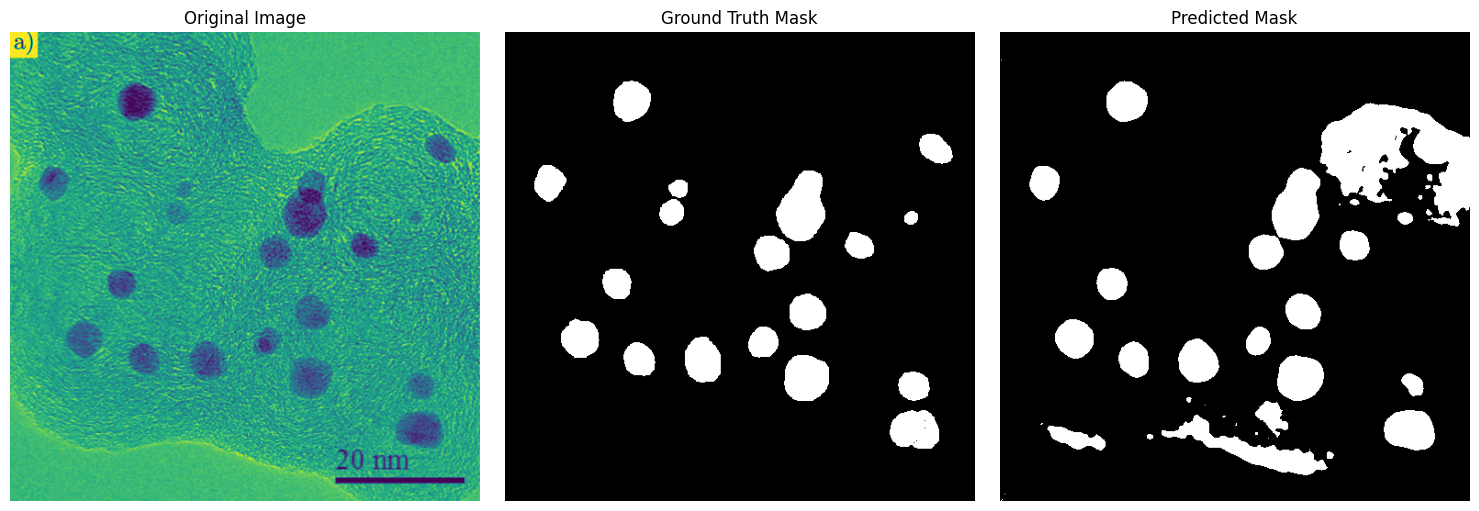

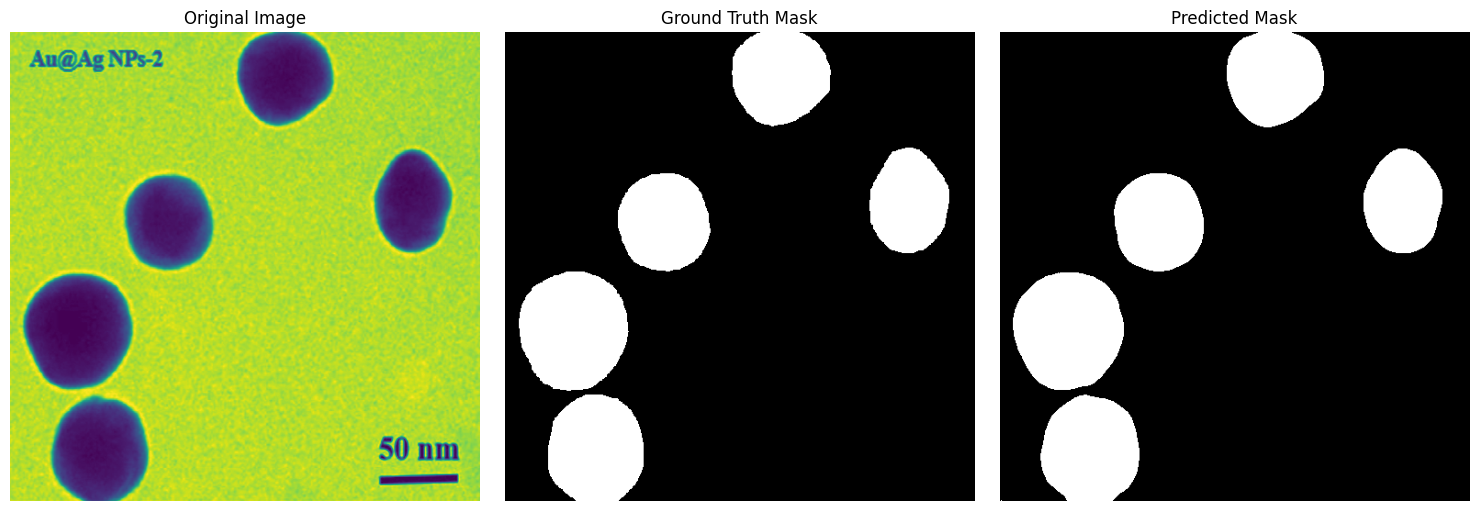

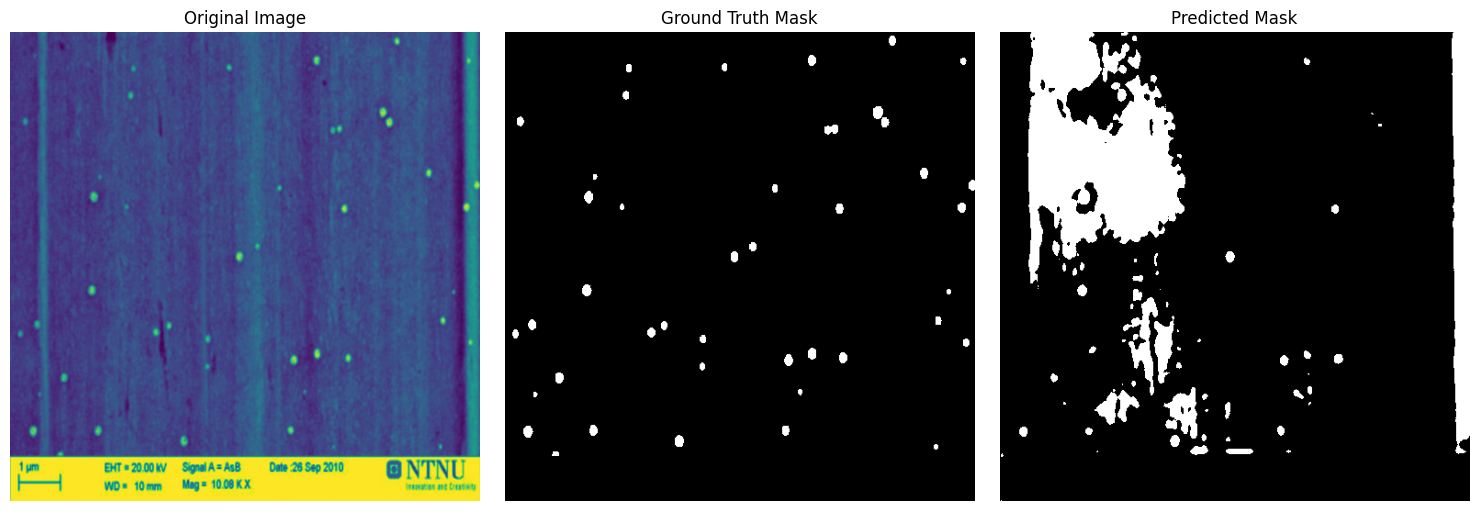

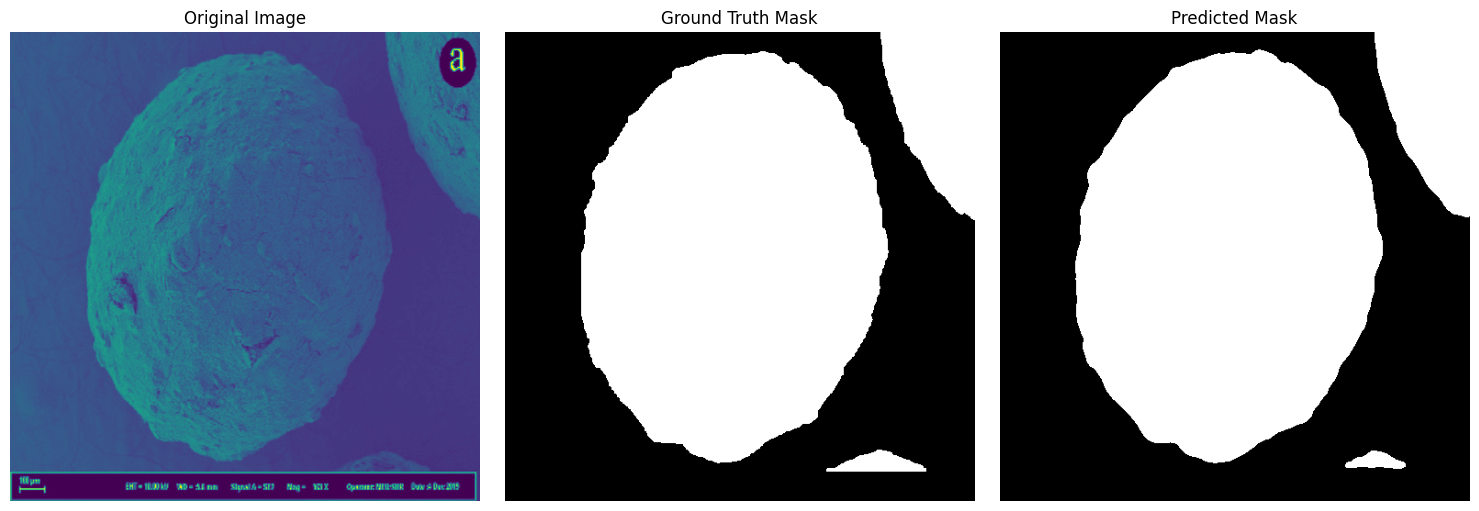

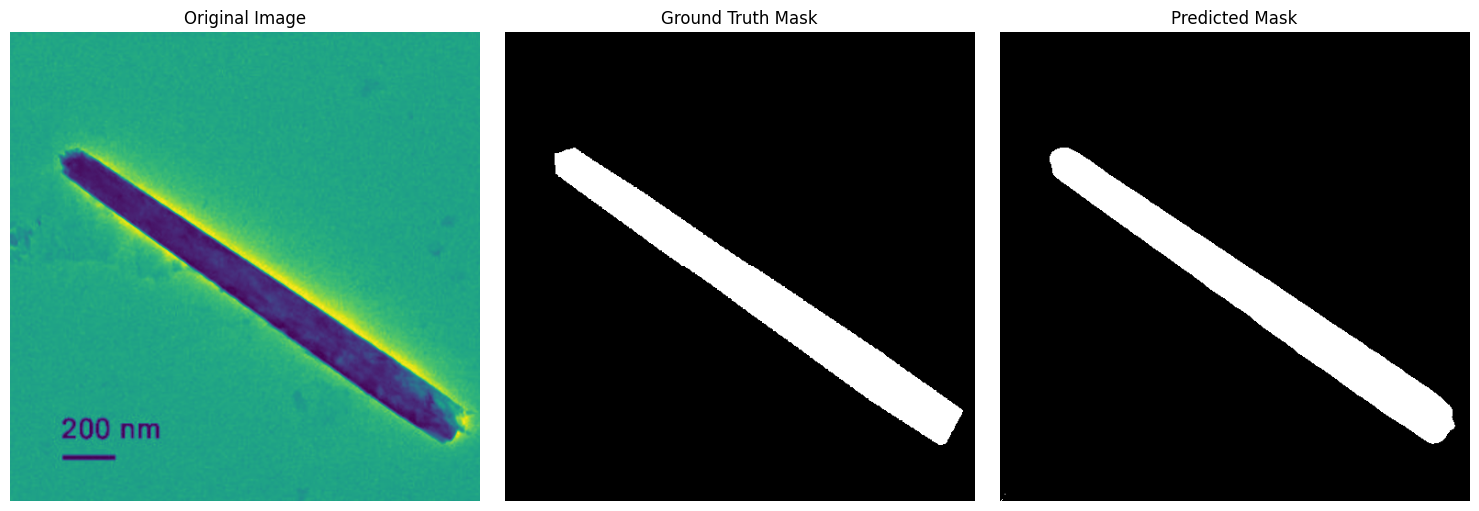

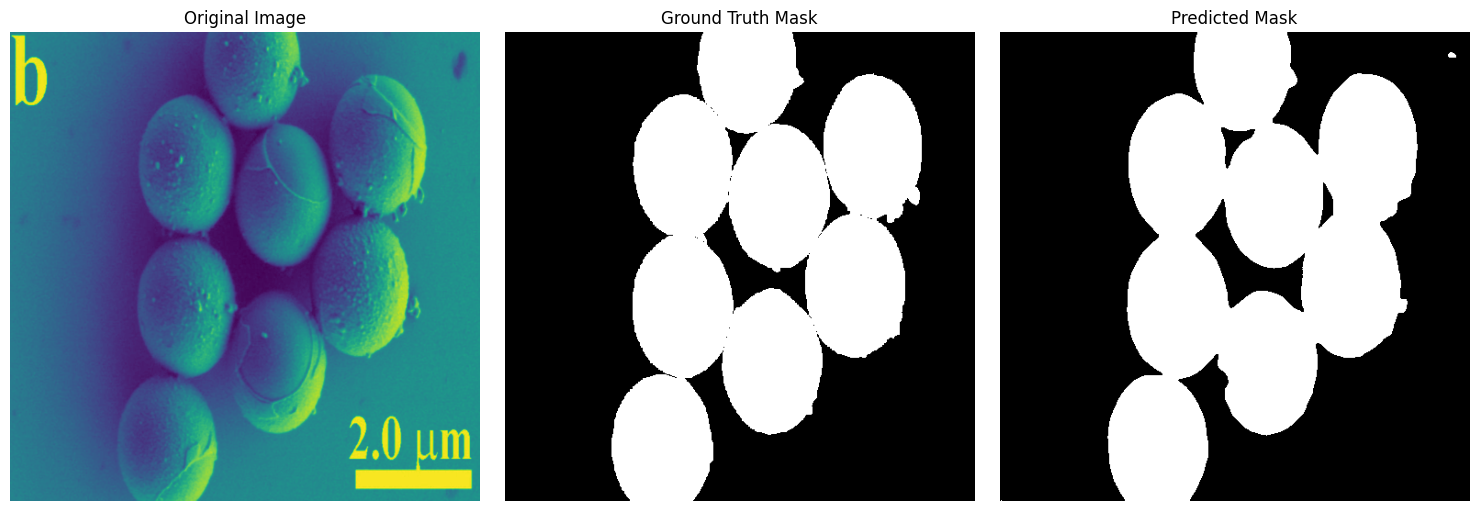

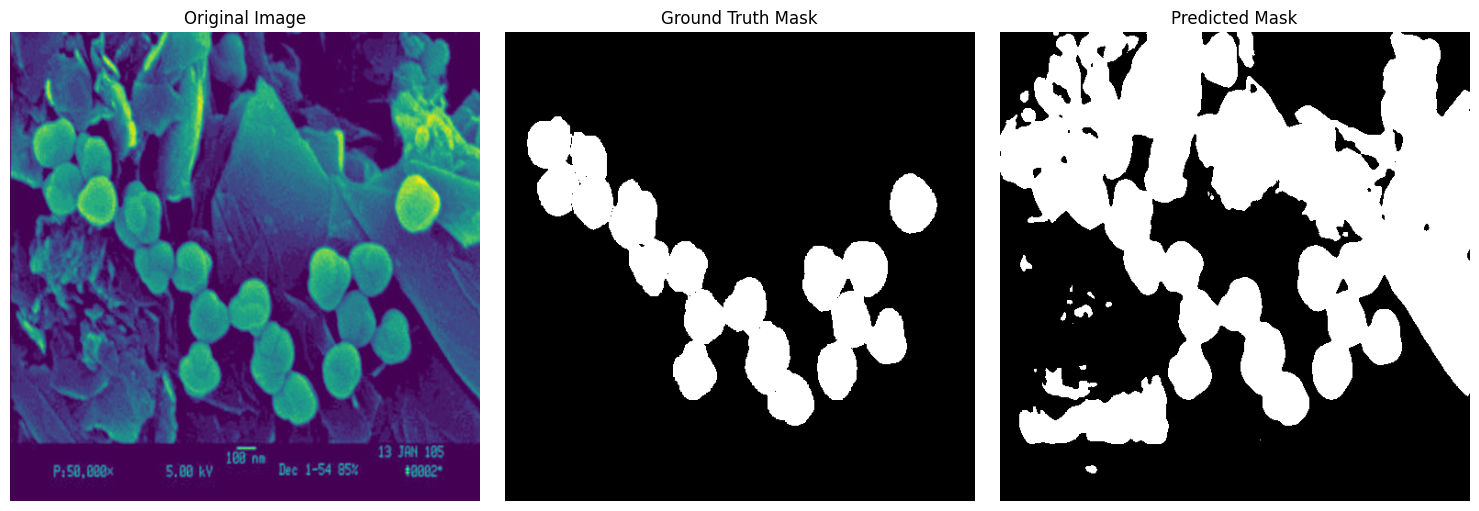

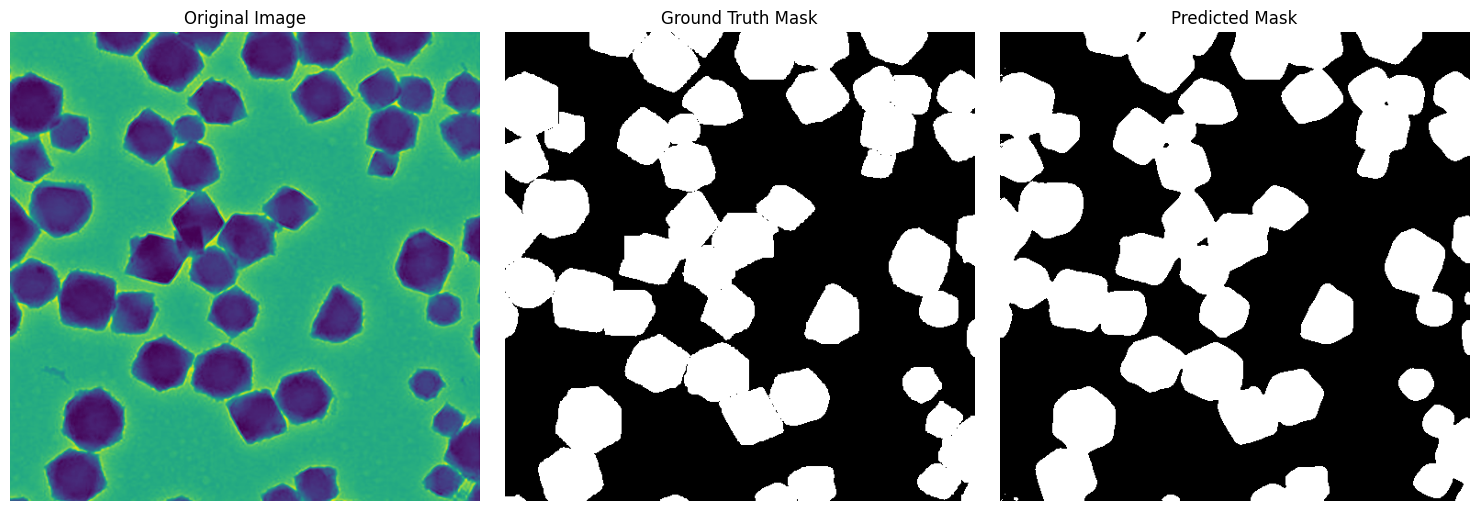

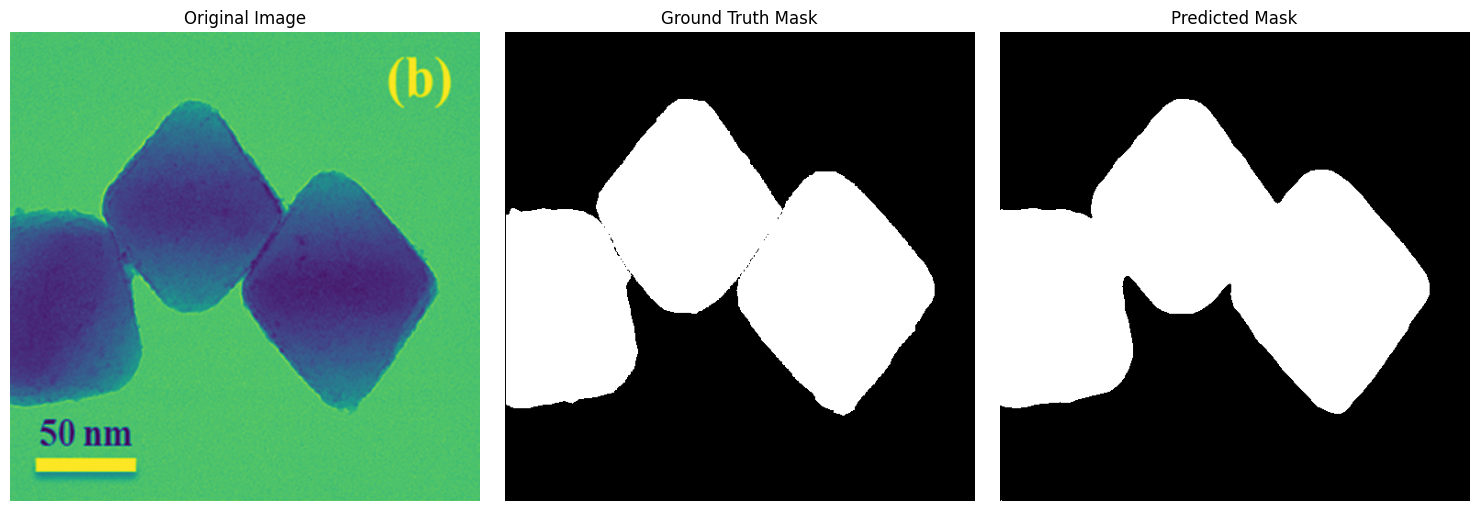

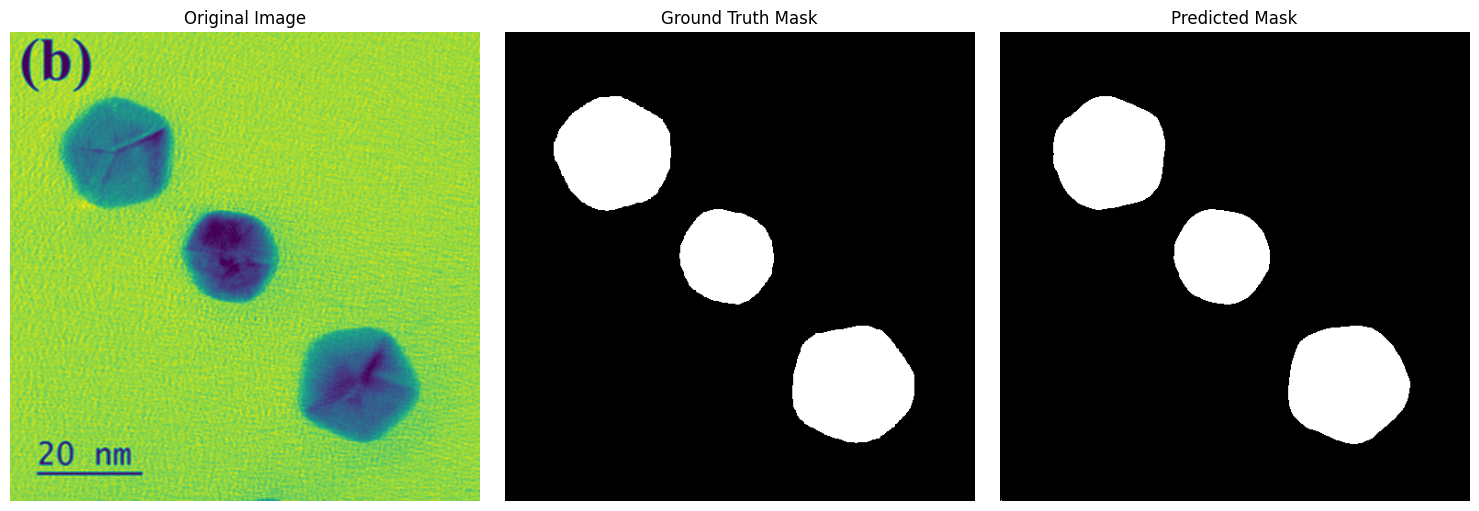

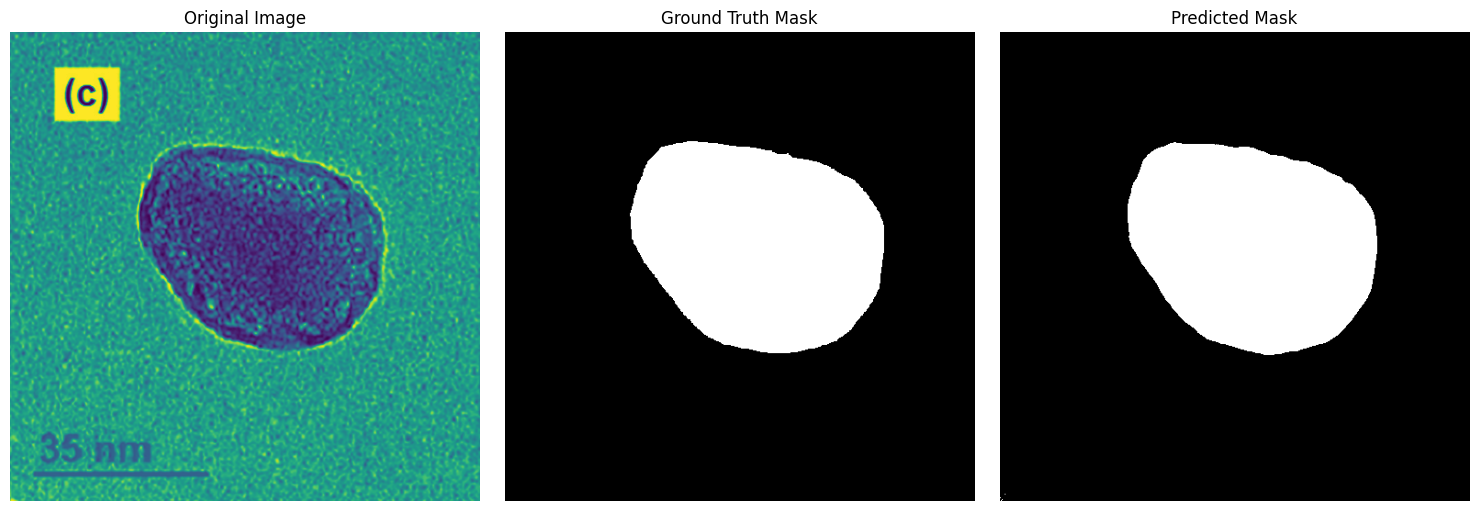

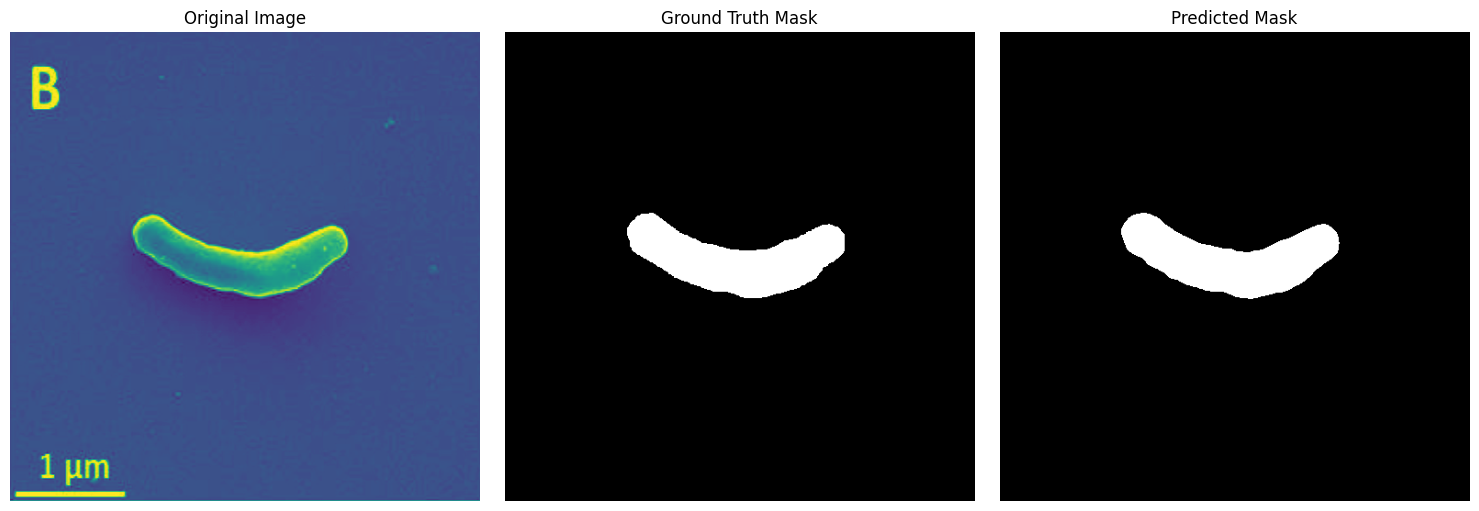

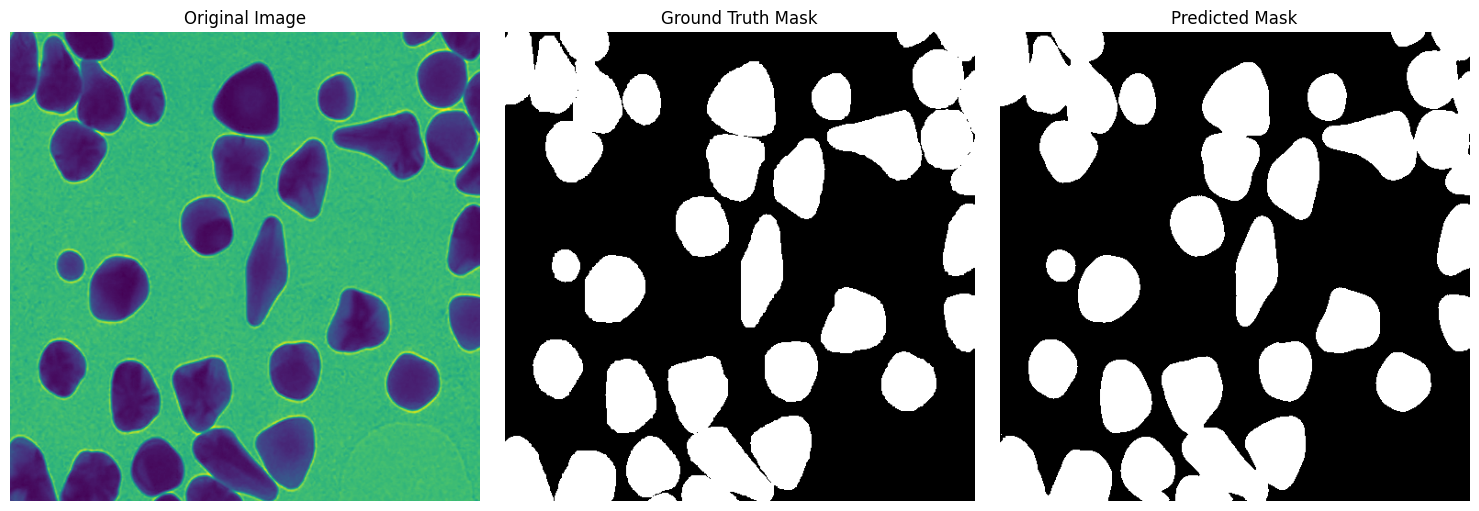

In [15]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    #img = img * std + mean  # Denormalize
    #img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    #plt.savefig(f"epoch_{epoch+1}_image_{i}.png")
    plt.tight_layout()
    plt.show()


In [16]:
import pandas as pd
data = {
    "epoch": epochs,
    "train_loss": train_loss_data,
    "val_loss": val_loss_data,
    "precision": precision_data,
    "recall": recall_data,
    "accuracy": accuracy_data,
    "iou": iou_data,
    "f1": f1_data,
    "dice_coeff": dice_coeff_data,
    "rand_error": rand_error_data,
    "pixel_error": pixel_error_data
}

metrics_df = pd.DataFrame(data)
print(metrics_df)
metrics_df.to_csv("training_metrics.csv", index=False)

    epoch  train_loss  val_loss  precision    recall  accuracy           iou  \
0       1    0.653314  0.689255   0.000000  0.000000  0.679865  8.234864e-13   
1       2    0.611579  0.658853   0.911540  0.661612  0.871115  6.214497e-01   
2       3    0.519498  0.528006   0.938103  0.912426  0.952692  8.570058e-01   
3       4    0.468430  0.508705   0.917026  0.959094  0.959123  8.804748e-01   
4       5    0.443297  0.497817   0.939004  0.900371  0.949382  8.439306e-01   
..    ...         ...       ...        ...       ...       ...           ...   
95     96    0.105021  0.132326   0.956972  0.961524  0.973842  9.240048e-01   
96     97    0.105452  0.132096   0.970090  0.953673  0.975756  9.288784e-01   
97     98    0.103107  0.137388   0.964258  0.961084  0.976137  9.301783e-01   
98     99    0.103757  0.132328   0.964900  0.961298  0.976415  9.310103e-01   
99    100    0.102276  0.136738   0.962713  0.964438  0.976657  9.316002e-01   

          f1    dice_coeff  rand_error 